# importing data

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="darkgrid")



from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid

## reading data

In [2]:
co2_df = pd.read_csv('data/co2_concentration_df.csv')
co2_df['datetime'] = co2_df['datetime'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
co2_df.set_index('datetime', inplace=True)
co2_diff = pd.DataFrame(co2_df['data_mean_global'].pct_change())
co2_diff.dropna(inplace=True)

In [3]:
#co2_diff = co2_diff.tail(1380)
co2_diff

,data_mean_global
datetime,
1677-11-15,0.003653
1677-12-15,0.002309
1678-01-15,0.001664
1678-02-15,0.001382
1678-03-15,0.001232
...,...
2014-08-15,-0.002718
2014-09-15,0.001149
2014-10-15,0.004157


In [4]:
global_temp_df = pd.read_csv('data/global_temp_df.csv')
global_temp_df['dt'] = global_temp_df['dt'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
global_temp_df['dt'] = global_temp_df['dt'].apply(lambda x: x.replace(day=15))
global_temp_df.set_index('dt', inplace=True)
global_temp_diff = pd.DataFrame(global_temp_df['LandAndOceanAverageTemperature'].pct_change())
global_temp_diff.dropna(inplace=True)
global_temp_diff.index.name = 'datetime'

## lagged data

In [5]:
lagged_df = pd.DataFrame()

In [6]:
for i in range(12, 0, -1):
    lagged_df[['t-' + str(i)]] = co2_diff.shift(i)
    
lagged_df.dropna(axis=0, inplace=True)

In [7]:
lagged_df = pd.merge(lagged_df, global_temp_diff, left_on='datetime', right_on='datetime')

In [8]:
lagged_df

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,LandAndOceanAverageTemperature
datetime,,,,,,,,,,,,,
1850-02-15,0.001374,0.001227,0.000870,-0.000169,-0.002536,-0.005725,-0.005629,-0.000117,0.003702,0.003572,0.002264,0.001609,0.058833
1850-03-15,0.001227,0.000870,-0.000169,-0.002536,-0.005725,-0.005629,-0.000117,0.003702,0.003572,0.002264,0.001609,0.001366,0.033485
1850-04-15,0.000870,-0.000169,-0.002536,-0.005725,-0.005629,-0.000117,0.003702,0.003572,0.002264,0.001609,0.001366,0.001223,0.044435
1850-05-15,-0.000169,-0.002536,-0.005725,-0.005629,-0.000117,0.003702,0.003572,0.002264,0.001609,0.001366,0.001223,0.000869,0.057271
1850-06-15,-0.002536,-0.005725,-0.005629,-0.000117,0.003702,0.003572,0.002264,0.001609,0.001366,0.001223,0.000869,-0.000158,0.054556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-15,-0.002676,0.001169,0.004069,0.003711,0.002352,0.002065,0.000955,0.000575,0.000187,-0.001179,-0.003227,-0.004250,0.005655
2014-09-15,0.001169,0.004069,0.003711,0.002352,0.002065,0.000955,0.000575,0.000187,-0.001179,-0.003227,-0.004250,-0.002718,-0.035895
2014-10-15,0.004069,0.003711,0.002352,0.002065,0.000955,0.000575,0.000187,-0.001179,-0.003227,-0.004250,-0.002718,0.001149,-0.055729


## splitting data

In [9]:
X = lagged_df.iloc[:, :-1].values
y = lagged_df.iloc[:, -1:].values

In [10]:
train_size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X[0:train_size], X[train_size:len(X)], y[0:train_size], y[train_size:len(X)]

## Decicion Tree

In [11]:
dt = DecisionTreeRegressor(max_depth= 5)
dt.fit(X_train, y_train)

print('train score: ' + str(dt.score(X_train, y_train)))
print('test score: ' + str(dt.score(X_test, y_test)))

train score: 0.9603414434666729
test score: 0.9252383273654768


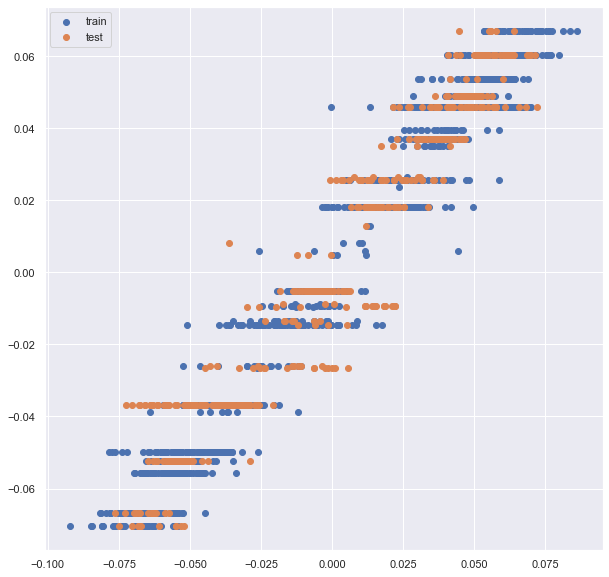

In [12]:
plt.subplots(figsize=(10,10))

# making predictions
train_prediction = dt.predict(X_train)
test_prediction = dt.predict(X_test)

# scatter with predictions and actual values


plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

## Random Forest

In [13]:
rfr = RandomForestRegressor(n_estimators=200, random_state=42)
rfr.fit(X_train, y_train.ravel())

print('train score: ' + str(rfr.score(X_train, y_train)))
print('train score: ' + str(rfr.score(X_test, y_test)))

train score: 0.9927296784347218
train score: 0.9458922282370388


### grid search

In [14]:
grid = {'n_estimators': [50, 100, 200], 'max_depth': {3, 5, 7}, 'max_features': [2,3,4,5,6,7,8,9,10,11,12], 'random_state': [42]}
test_scores = []

In [15]:
for g in ParameterGrid(grid):
    rfr.set_params(**g)
    rfr.fit(X_train, y_train.ravel())
    test_scores.append(rfr.score(X_test, y_test))

In [16]:
best_score_index = np.argmax(test_scores)
bestGrid = list(ParameterGrid(grid))[best_score_index]
print(test_scores[best_score_index], bestGrid)

0.9616978571116176 {'max_depth': 7, 'max_features': 2, 'n_estimators': 100, 'random_state': 42}


In [17]:
rfr.set_params(**bestGrid)
rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=7, max_features=2, random_state=42)

In [18]:
print('train score: ' + str(rfr.score(X_train, y_train)))
print('train score: ' + str(rfr.score(X_test, y_test)))

train score: 0.9706492108003976
train score: 0.9616978571116176


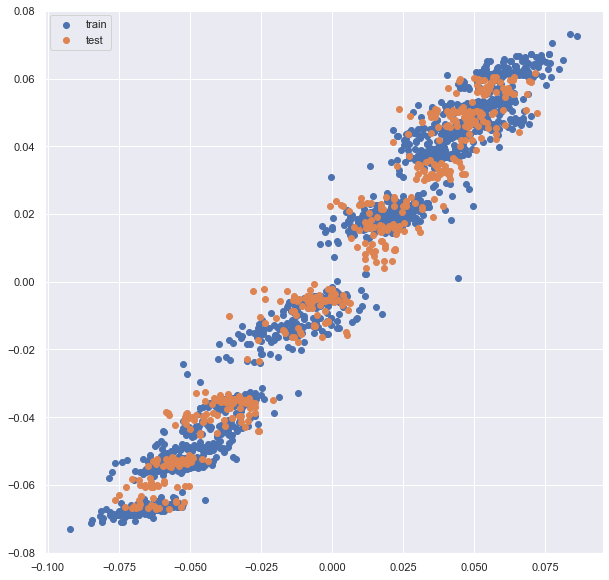

In [19]:
plt.subplots(figsize=(10,10))

# making predictions
train_prediction = rfr.predict(X_train)
test_prediction = rfr.predict(X_test)

# scatter with predictions and actual values
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

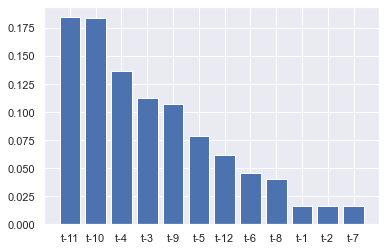

In [20]:
# importances of each feature in the model
importances = rfr.feature_importances_

# sort index by importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# label names
names = ['t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1']
# labels to importances
labels = np.array(names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)

plt.show()

## gradient boost tree regressor

In [21]:
gbr = GradientBoostingRegressor(max_features=2, learning_rate=0.01, n_estimators=50, subsample=0.6, random_state=42)
gbr.fit(X_train, y_train.ravel())
print('train score: ' + str(gbr.score(X_train, y_train)))
print('test score: ' + str(gbr.score(X_test, y_test)))

train score: 0.5906213692050755
test score: 0.594430376578633


### grid

In [22]:
grid = {'n_estimators': [50, 100, 200], 'max_depth': {3, 5, 7}, 'max_features': [2,3,4,5,6,7,8,9,10,11,12], 'learning_rate': [0.6,0.7,0.8,0.9], 'learning_rate': [0.01, 0.005, 0.02, 0.05, 0.1] ,'random_state': [42]}
test_scores = []

In [23]:
for g in ParameterGrid(grid):
    gbr.set_params(**g)
    gbr.fit(X_train, y_train.ravel())
    test_scores.append(gbr.score(X_test, y_test))

In [24]:
best_score_index = np.argmax(test_scores)
best_grid = list(ParameterGrid(grid))[5]
print(test_scores[best_score_index], best_grid)

0.9588632205428081 {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 3, 'n_estimators': 200, 'random_state': 42}


In [25]:
gbr.set_params(**best_grid)
gbr.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.01, max_features=3, n_estimators=200,
                          random_state=42, subsample=0.6)

In [26]:
print('train score: ' + str(gbr.score(X_train, y_train)))
print('test score: ' + str(gbr.score(X_test, y_test)))

train score: 0.9371134051453425
test score: 0.9358301718578402


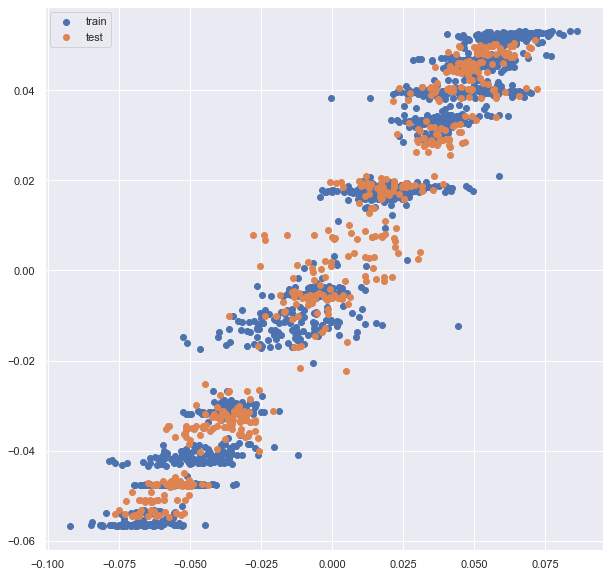

In [27]:
plt.subplots(figsize=(10,10))

# making predictions
train_prediction = gbr.predict(X_train)
test_prediction = gbr.predict(X_test)

# scatter with predictions and actual values
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

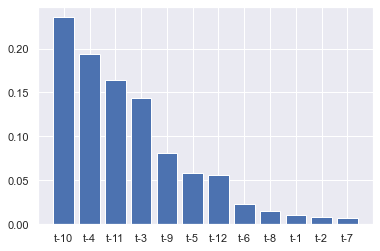

In [28]:
# importances of each feature in the model
importances = gbr.feature_importances_

# sort index by importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# label names
names = ['t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1']
# labels to importances
labels = np.array(names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)

plt.show()